### Loading Dependencies

In [ ]:
!pip install python-docx
import re
import glob
from docx import Document 
import unicodedata

     |████████████████████████████████| 5.5MB 7.4MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=d10227cfc08512d6e31130236978041d882a406243c862af461b363f4b05c568
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


In [ ]:
# https://discuss.huggingface.co/t/error-with-new-tokenizers-urgent/2847/5
!pip install --no-cache-dir transformers sentencepiece

     |████████████████████████████████| 1.5MB 7.9MB/s 
     |████████████████████████████████| 1.1MB 34.1MB/s 
     |████████████████████████████████| 890kB 51.0MB/s 
     |████████████████████████████████| 2.9MB 55.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a6d69948c1d52bbb2e3c5f35d84a858004996bfefac0f8adb06729b96c0d3f32
  Stored in directory: /tmp/pip-ephem-wheel-cache-gn1bpe9i/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Loading the data:

In [ ]:
# We pushed the SOW documents on github and clone the github repo whenever we need the documents
#This is faster than mounting our colab notebook to google drive
!git clone https://github.com/NLP-Contracts/NLP-summarization.git

Cloning into 'NLP-summarization'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 27 (delta 3), reused 25 (delta 1), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [ ]:
%cd NLP-summarization/Sample\ SoW\ docs

/content/NLP-summarization/Sample SoW docs


In [ ]:
list_docsNames = glob.glob('*.docx') #USING GLOB TO GET NAMES OF PROJECTS
 
docs = []
st = ""
for docsName in list_docsNames:
  docs.append(st.join([p.text for p in Document(docsName).paragraphs])) #USING DOCUMENT TO LOAD PROJECTS

In [ ]:
list_docsNames[0]

'TI_SOW_58_2019_TM_MITS_Stratus_mock.docx'

### Data Cleaning:

In [ ]:
#GENERIC CLEANING METHODS
# The basic_cleaner function will be applied first in the main corpus 
#at which we will select the sections using regex pattern matching
def basic_cleaner(s):
  s = s.lower()
  s = re.sub(r'\n', '', s)
  s = re.sub(r'\t', '', s)
  s = re.sub(r' + ', '', s)
  return(s)
#after select each section using regex pattern matching
#we apply the extra_cleaner function to remove punctuations 
#excpet "." & ",", in addition the section numbers and information inside brackets 
# will be removed as well
def extra_cleaner(s):
  # s= re.sub(',', ' ', s)
  s= re.sub('/', '', s)
  s= re.sub(':', '', s)
  s= re.sub('\'', '', s)
  s= re.sub('-', '', s)
  s= re.sub('/', '', s)
  s= re.sub('<', '', s)
  s= re.sub('>', '', s)
  s=re.sub(r'\d{1,2}\.\d', '', s) # remove subsection numbers by removing digit numbers (that have)\d{1,2}\.\d pattern
  s=re.sub(r'\([^)]*\)', '', s) #remove brakets and anything thats inside the brakets
  return(s)
 
c_docs = [basic_cleaner(_) for _ in docs]


### Section Selection 

Going over the SOW documents it was evident that some sections had little informative information that could be beneficial for the summarization model to generate valuable results. As such we excluded sections: 


1.   Descriptions
2.   Definitions
3.   Reports
4.   Addresses for Administration and Invoicing, and 
5.  The Appendixes 



In [ ]:
# It has to be noted that often the section names are not consistant in all documents that is why we applied an "or", "|" symbol 
# to find either or matched of a string.For instance the "section9_charges" section has 
#"charges, expenses and payment terms" and in some documents"fees, expenses and payment terms" or "expenses and payment terms"
#which represnet the same section 
section3_services=[' '.join(map(str, (re.findall('(?:.0services?|.sevices?| services 3.1?)(.*?) (?:term and schedule?|and schedule?|term and?)', i)))) for i in c_docs]
section4_schedule=[' '.join(map(str, (re.findall('(?:term and schedule?|and schedule?|term and?)(.*?)(?:place of performance?|place of performance and hours?|performance and hours)', i)))) for i in c_docs]
section5_PPH = [' '.join(map(str, (re.findall('(?:place of performance and hours?|performance and hours?)(.*?)(?:structure and roles|and roles?)', i)))) for i in c_docs]
section6_roles = [' '.join(map(str, (re.findall('(?:structure and roles ?|and roles?)(.*?)(?:general responsibilities|responsibilities?)', i)))) for i in c_docs]
section7_responsibilities = [' '.join(map(str, (re.findall('(?:general responsibilities)(.*?)(?:charges, expenses and payment terms|fees, expenses and payment terms?|expenses and payment terms?|milestones, deliverables, and acceptance criteria?|8.0 intentionally left blank?|.0 intentionally left blank)', i)))) for i in c_docs]
section9_charges = [' '.join(map(str, (re.findall('(?:charges, expenses and payment terms|fees, expenses and payment terms?|expenses and payment terms?)(.*?)(?:specific service levels)', i)))) for i in c_docs]
section12_assumptions=[' '.join(map(str, (re.findall('(?:assumptions and additional provisions?)(.*?)(?:addresses for administration and invoicing)', i)))) for i in c_docs]
section14_agreement = [' '.join(map(str, (re.findall('(?:.0 agreement?)(.*?)(?:agreed and accepted?)', i)))) for i in c_docs]

#Applyinf the "extra_cleaner" function to take out brackets, subsection numbers and most of the punctuations
c_section3_services = [extra_cleaner(i) for i in section3_services]
c_section4_schedule = [extra_cleaner(i) for i in section4_schedule]
c_section5_PPH = [extra_cleaner(i) for i in section5_PPH]
c_section6_roles = [extra_cleaner(i) for i in section6_roles]
c_section7_responsibilities = [extra_cleaner(i) for i in section7_responsibilities]
c_section9_charges = [extra_cleaner(i) for i in section9_charges]
c_section12_assumptions = [extra_cleaner(i) for i in section12_assumptions]
c_section14_agreement = [extra_cleaner(i) for i in section14_agreement]
# This corpus is the collection of sections which we selectively chose to remain in the document
corpus = [] 
for i in range(len(docs)): # range of the loop is the number of documents that are introduced 
  corpus.append(c_section3_services[i] + "\n"+ c_section4_schedule[i] + "\n" + c_section5_PPH[i] + "\n" + c_section6_roles[i] + "\n" + c_section7_responsibilities[i] + "\n" + c_section9_charges[i] + "\n" + c_section12_assumptions[i] + "\n" + c_section14_agreement[i])

In [ ]:
c_section4_schedule[0]

'this statement of work shall commence on january, 01st, 2019  and shall end on december, 31st, 2019 , with the period from sow start date to sow end date referred to as , unless terminated earlier in accordance with the agreement.unless otherwise indicated to ti 30 days prior to the end of the initial or renewal term, the extension of the end date and this sow shall be renewed for a period of one  month at the same terms and conditions as were in effect as of the date just prior to renewal.the same notification process and telus option to nonrenewal for additional one  month terms shall apply at the end of each renewal term.without limiting the terms of the agreement, any time during the sow term, telus may terminate this sow early for convenience by providing ti with a notice of at least thirty  calendar days.'

#T5 Model Explained

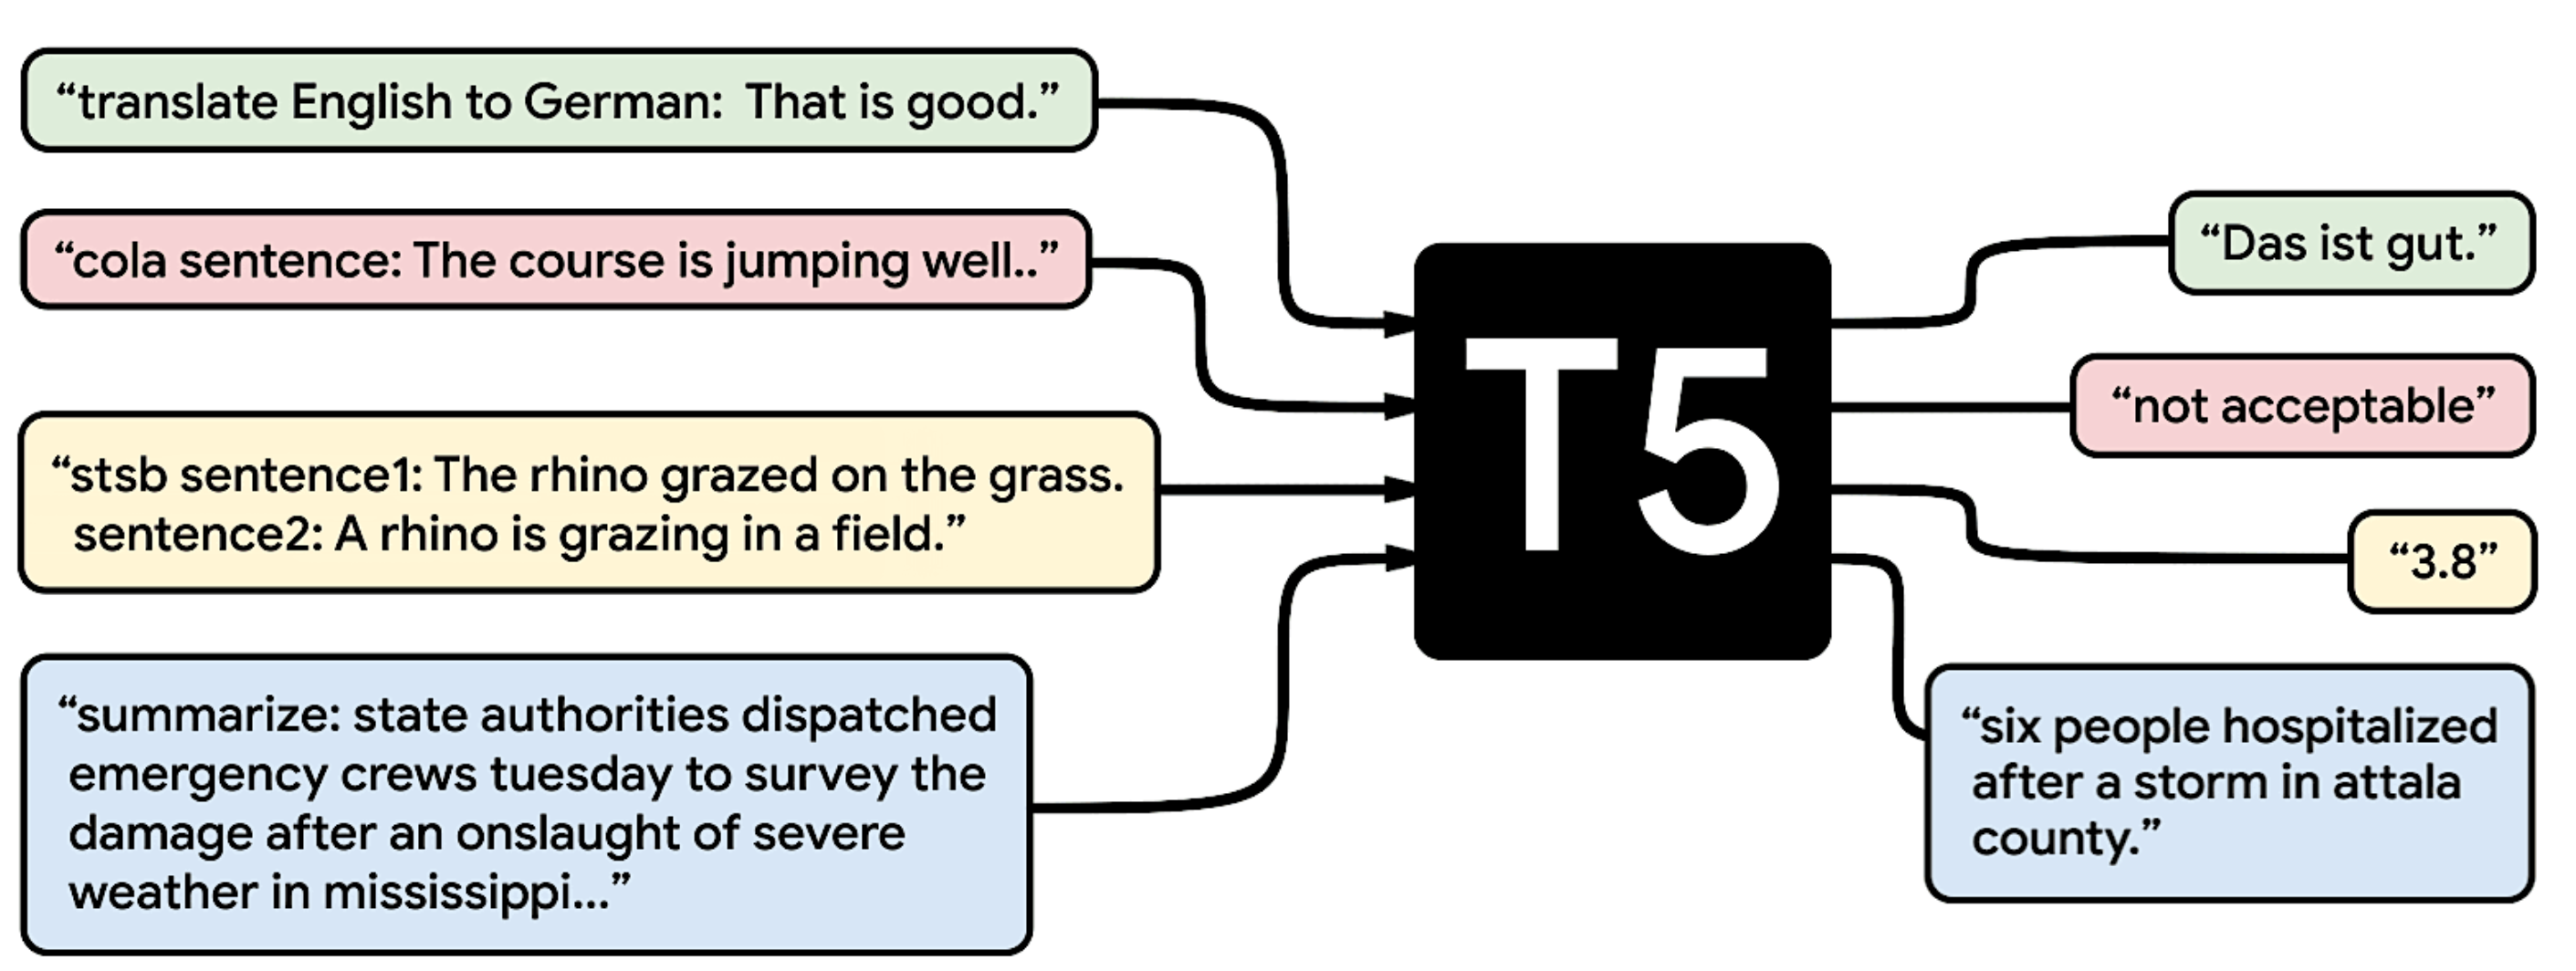

**T5** is an **encoder-decoder** model **pre-trained** on a multi-task **mixture of unsupervised and supervised tasks** and for which each task is converted into a **text-to-text** format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

We also introduce a new open-source pre-training dataset, called the **Colossal Clean Crawled Corpus (C4)**. The T5 model, pre-trained on C4, achieves state-of-the-art results on many NLP benchmarks while being flexible enough to be fine-tuned to a variety of important downstream tasks.

Reference link: https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html

 Existing pre-training datasets don’t meet all three of these criteria — for example, text from Wikipedia is high quality, but uniform in style and relatively small for our purposes, while the Common Crawl web scrapes are enormous and highly diverse, but fairly low quality.

To satisfy these requirements, we developed the Colossal Clean Crawled Corpus (C4), a cleaned version of Common Crawl that is two orders of magnitude larger than Wikipedia. Our cleaning process involved deduplication, discarding incomplete sentences, and removing offensive or noisy content. This filtering led to better results on downstream tasks, while the additional size allowed the model size to increase without overfitting during pre-training.

The **T5 model** was presented in "***Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer"*** by Colin Raffel, Noam Shazeer, Adam Roberts, Katherine Lee, Sharan Narang, Michael Matena, Yanqi Zhou, Wei Li, Peter J. Liu.

For **sequence-to-sequence generation**, it is recommended to use **T5ForConditionalGeneration.generate()**`.  

This method takes care of feeding the encoded input via cross-attention layers to the decoder and auto-regressively generates the decoder output. - T5 uses relative scalar embeddings. Encoder input padding can be done on the left and on the right.


---
Which we will be doing by applying model.generate() in our t5_section function

Reference Link: https://huggingface.co/transformers/model_doc/t5.html

Model and tokenizer initialization: 

Here we used **pretrained T5-smal**l for this task which has **60 million parameters** Available

 other versions:

*   T5-base =220 million parameters
*   T5-large =770 million parameters
*   T5–3B =3 billion parameters
*   T5–11B = 11 billion parameters






In [ ]:
#Importing the t5 transformers as well as its pre-trained model called "t5-small"
import torch
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
model = TFT5ForConditionalGeneration.from_pretrained('t5-small') 
tokenizer = T5Tokenizer.from_pretrained('t5-small')

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


# We are using Corpus[0]  
AKA--> TI_SOW_58_2019_TM_MITS_Stratus_mock.docx as our sample document to display our summarization results
It must be noted that we tested our model for all documents but for easy representation of our result we just decided to show one sample corpus to Mahmadul. 

#t5_full_sec_doc Summartization function

In [ ]:
def t5_full_sec_doc(doc_num):
  Text = corpus[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              min_length=90,
                              max_length=300,
                              num_beams=3,
                              num_return_sequences=1,
                              repetition_penalty=2.5,
                             
                              )
  full_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")
  return full_sum

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy
def summaize_full_sec_doc(n_doc):
  
  sum_full_sec= t5_full_sec_doc(n_doc).capitalize()
    
  if nlp(sum_full_sec).ents:
    displacy.render(nlp(sum_full_sec), style="ent",jupyter=True) # shows the Named Entity Recognition labels as highlights if applicable to that summary
                                                        # This will assist the reader while looking at the summarized document
  else:
    display(sum_full_sec)                                 #If The section doesnt have NER labels then display the summarized section as is 
  print("\033[95m" + "Overal total words from the sectioned document After Summarization:"+ "\033[0m",(len(sum_full_sec.split())))
  print("\033[95m" + "Overal total words from the sectioned document before Summarization:"+ "\033[0m",(len(corpus[n_doc].split())))
  print("\033[95m" + "Ratio to the Original document: %"+ "\033[0m",(len(sum_full_sec.split())/(len(corpus[n_doc].split()))*100))
  print("\033[95m" + "Overal Orignal document words before Summarization:"+ "\033[0m",(len(c_docs[n_doc].split())))
  print("\033[95m" + "Ratio to the Original document: %"+ "\033[0m",(len(sum_full_sec.split())/(len(c_docs[n_doc].split()))*100))


#Result/ Excecution of the t5_full_sec_doc Summarization function

**This result shows that the T5 model doesnt retain valuable information such as starting and ending dates of the contract as well as the charges (CAD) related to the contract with only 72 words. That is why we approached this problem by summarizing the document section by section to retain the valuable information for whomever reading the summarized document.**


In [ ]:
summaize_full_sec_doc(0)

Overal total words from the sectioned document After Summarization: 72
Overal total words from the sectioned document before Summarization: 2452
Ratio to the Original document: % 2.936378466557912
Overal Orignal document words before Summarization: 4246
Ratio to the Original document: % 1.6957136128120585


#t5_section_constant_par Summarization function

In [ ]:
def t5_section_constant_par(doc_num):
  # In t5_selection we use a prepending "summarize" prefix + each section text 

 #Section3_services
  Text = c_section3_services[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              # min_length=60,
                              max_length=500,
                              num_beams=4,
                              # num_return_sequences=1,
                              # repetition_penalty=2.5,
                              early_stopping=True
                              )
  #PAD - your GPU (or CPU at worst) processes your training data in batches and all the sequences in your batch should have the same length. If the max length of your sequence is 8, your sentence My name is guotong1988 will be padded from either side to fit this length: My name is guotong1988 pad pad pad pad
  # refered link ----> https://github.com/nicolas-ivanov/tf_seq2seq_chatbot/issues/15
  service_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","") 
  
  # section4_schedule
  Text = c_section4_schedule[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              # min_length=60,
                              max_length=500,
                              num_beams=4,
                              # num_return_sequences=1,
                              # repetition_penalty=2.5,
                              early_stopping=True
                              )

  schedule_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")


  Text = c_section5_PPH[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              min_length=60,
                              max_length=400,
                              num_beams=4,
                              early_stopping=True
                              
                              )

  PPH_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")



  Text = c_section6_roles[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              min_length=60,
                              max_length=400,
                              num_beams=2,
                              early_stopping=True
                              )

  role_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")

  Text = c_section7_responsibilities[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              max_length=400,
                              num_beams=3,
                       
                              early_stopping=True
                              )

  resp_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")

  Text = c_section9_charges[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              max_length=400,
                              num_beams=4,
                              early_stopping=True
                              )

  charge_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")


  Text = c_section12_assumptions[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              max_length=400,
                              num_beams=4,
                              early_stopping=True
                          )

  assum_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")

  Text = c_section14_agreement[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              max_length=400,
                              num_beams=4,
                              early_stopping=True
                              )

  agree_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")
  agree_sum=agree_sum.capitalize()
  return service_sum,schedule_sum,PPH_sum,role_sum,resp_sum, charge_sum,assum_sum,agree_sum


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy
def summaize_by_section__constant_par(n_doc):
  
  service_sum,schedule_sum,PPH_sum,role_sum,resp_sum, charge_sum,assum_sum,agree_sum= t5_section__constant_par(n_doc) #This function t5_section(n_doc) 
                                                                                                        #will select the document number 
                                                                                                        #which we want to summarize and spits out seven
                                                                                                        #summarized sections which will be displayed in the 
                                                                                                        #for loop below
  original_sections=[c_section3_services,c_section4_schedule,c_section5_PPH,c_section6_roles,c_section7_responsibilities,c_section9_charges,c_section12_assumptions,c_section14_agreement]
  sum_sections={"Services":service_sum,
            "Schedule":schedule_sum,
            "Place of Performance and Hours":PPH_sum,
            "Role":role_sum,
            "Responsibilities":resp_sum,
            "Charge":charge_sum,
            "Assumptions":assum_sum,
            "Agreement":agree_sum}

  for v,i in zip(sum_sections.items(),original_sections): #I zipped sum_sections and original_sections so to display 
                                                          #the length of words in the original_sections before summarization and after summarization

    print("\033[95m" + v[0]+ "\033[0m") #sum_sections is a dictionary which in a zip will be transformed to a list of lists 
                                        #where the list with index 0 becomes the keys and 
                                        #list with index 1 becomes the summarized strings
                                        #This print will display the section names
    print("\t")


    if nlp(v[1]).ents:
     displacy.render(nlp(v[1]), style="ent",jupyter=True) # shows the Named Entity Recognition labels as highlights if applicable to that summary
                                                          # This will assist the reader while looking at the summarized document
    else:
      display(v[1])                                       #If The section doesnt have NER labels then display the summarized section as is 
    
    print("\t")
    print("\033[33m" + "summarized lenght of section"+ "\033[0m",len(v[1].split())) # displays the word length of the sum_sections 
    print("\033[33m" + "original lenght of section"+ "\033[0m",len(i[n_doc].split())) # displays the word length of the original_sections 
    
#this for loop below helps in calculating the overal word lenght of the full summarized document with all sections 
  sum=0
  h=[]
  for k,v in sum_sections.items():
    h.append(len(v.split()))
  for i in h:
    sum=i+sum
  print("\t")
  print("\033[95m" + "Overal total words from the sectioned document in the Summarized Version:"+ "\033[0m",sum)
  print("\033[95m" + "Overal total words from the sectioned document before Summarization:"+ "\033[0m",(len(corpus[n_doc].split())))
  print("\033[95m" + "Ratio to the sectioned document: %"+ "\033[0m",(sum/(len(corpus[n_doc].split())))*100)
  print("\033[95m" + "Overal Orignal document words before Summarization:"+ "\033[0m",(len(c_docs[n_doc].split())))
  print("\033[95m" + "Ratio to the Original document: %"+ "\033[0m",(sum/(len(c_docs[n_doc].split())))*100)

    

# Result/ Excecution of the t5_section_n__constant_par Summarization function

In [ ]:
summaize_by_section__constant_par(0)

Services
	


	
summarized lenght of section 34
original lenght of section 122
Schedule
	


	
summarized lenght of section 58
original lenght of section 147
Place of Performance and Hours
	


	
summarized lenght of section 49
original lenght of section 192
Role
	


' the ti manager will procure and manage ti service representatives as required in furtherance of its obligations under this sow. the telus manager shall cooperate with telus to perform reviews, ensure ti accomplishes the tasks, activities, services and scope outlined in this sow.'

	
summarized lenght of section 43
original lenght of section 375
Responsibilities
	


' ti responsibilitiesti will retain overall project management responsibility for all ti service levels and ti service level impacting activities. ti will follow direction of the telus manager and other managers as from time to time designated by the telus manager. the ti manager will proactively escalate issuesconcerns to the telus manager which may negatively impact ti’s ability to satisfactorily provide the services.'

	
summarized lenght of section 62
original lenght of section 383
Charge
	


	
summarized lenght of section 71
original lenght of section 585
Assumptions
	


	
summarized lenght of section 81
original lenght of section 577
Agreement
	


' the parties acknowledge and agree that the terms and conditions of the agreement shall govern this statement of work.counterparts. this sow and any change orders issued hereunder may be executed in counterparts, which when taken together will constitute one'

	
summarized lenght of section 39
original lenght of section 71
	
Overal total words from the sectioned document in the Summarized Version: 437
Overal total words from the sectioned document before Summarization: 2452
Ratio to the sectioned document: % 17.822185970636216
Overal Orignal document words before Summarization: 4246
Ratio to the Original document: % 10.292039566650965


#t5_section Summarization function_ Customized Parameters



In [ ]:
def t5_section(doc_num):
  # In t5_selection we use a prepending "summarize" prefix + each section text 

 #Section3_services
  Text = c_section3_services[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              # min_length=60,
                              max_length=500,
                              num_beams=3,
                              num_return_sequences=1,
                              repetition_penalty=2.5,
                              )
  #PAD - your GPU (or CPU at worst) processes your training data in batches and all the sequences in your batch should have the same length. If the max length of your sequence is 8, your sentence My name is guotong1988 will be padded from either side to fit this length: My name is guotong1988 pad pad pad pad
  # refered link ----> https://github.com/nicolas-ivanov/tf_seq2seq_chatbot/issues/15
  service_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","") 
  
  # section4_schedule
  Text = c_section4_schedule[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              min_length=60,
                              max_length=500,
                              num_beams=3,
                              num_return_sequences=1,
                              repetition_penalty=2.5,
                              )

  schedule_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")


  Text = c_section5_PPH[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              min_length=60,
                              max_length=400,
                              num_beams=4,
                              no_repeat_ngram_size=2,
                              num_return_sequences=1,
                              repetition_penalty=1.5,
                              early_stopping=True
                              
                              )

  PPH_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")



  Text = c_section6_roles[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              min_length=60,
                              max_length=400,
                              num_beams=2,
                              no_repeat_ngram_size=2,
                              num_return_sequences=1,
                              top_p=0.95,
                              
                              )

  role_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")

  Text = c_section7_responsibilities[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              max_length=500,
                              num_beams=3,
                              num_return_sequences=1,
                              top_p=0.95,
                              do_sample=True, 
                              early_stopping=True
                  
                              )

  resp_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")

  Text = c_section9_charges[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              max_length=1000,
                              num_beams=4,
                              num_return_sequences=1,
                              top_p=0.95,
                           
                              repetition_penalty=1.1,
                              
                              )

  charge_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")


  Text = c_section12_assumptions[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              max_length=400,
                              num_beams=10,
                              no_repeat_ngram_size=4,
                              num_return_sequences=1,
                              top_p=0.95,
                          )

  assum_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")

  Text = c_section14_agreement[doc_num].strip().replace("\n","")
  Preprocessed_text = "summarize: "+Text
  tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="tf")
  summary_ids = model.generate(tokens_input,
                              max_length=50,
                              num_beams=3,
                              no_repeat_ngram_size=2,
                              num_return_sequences=1,
                              top_p=0.95,
                              )

  agree_sum = tokenizer.decode(summary_ids[0]).strip().replace("<pad>","")
  agree_sum=agree_sum.capitalize()
  return service_sum,schedule_sum,PPH_sum,role_sum,resp_sum, charge_sum,assum_sum,agree_sum


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy
def summaize_by_section(n_doc):
  
  service_sum,schedule_sum,PPH_sum,role_sum,resp_sum, charge_sum,assum_sum,agree_sum= t5_section(n_doc) #This function t5_section(n_doc) 
                                                                                                        #will select the document number 
                                                                                                        #which we want to summarize and spits out seven
                                                                                                        #summarized sections which will be displayed in the 
                                                                                                        #for loop below
  original_sections=[c_section3_services,c_section4_schedule,c_section5_PPH,c_section6_roles,c_section7_responsibilities,c_section9_charges,c_section12_assumptions,c_section14_agreement]
  sum_sections={"Services":service_sum,
            "Schedule":schedule_sum,
            "Place of Performance and Hours":PPH_sum,
            "Role":role_sum,
            "Responsibilities":resp_sum,
            "Charge":charge_sum,
            "Assumptions":assum_sum,
            "Agreement":agree_sum}

  for v,i in zip(sum_sections.items(),original_sections): #I zipped sum_sections and original_sections so to display 
                                                          #the length of words in the original_sections before summarization and after summarization

    print("\033[95m" + v[0]+ "\033[0m") #sum_sections is a dictionary which in a zip will be transformed to a list of lists 
                                        #where the list with index 0 becomes the keys and 
                                        #list with index 1 becomes the summarized strings
                                        #This print will display the section names
    print("\t")


    if nlp(v[1]).ents:
     displacy.render(nlp(v[1]), style="ent",jupyter=True) # shows the Named Entity Recognition labels as highlights if applicable to that summary
                                                          # This will assist the reader while looking at the summarized document
    else:
      display(v[1])                                       #If The section doesnt have NER labels then display the summarized section as is 
    
    print("\t")
    print("\033[33m" + "summarized lenght of section"+ "\033[0m",len(v[1].split())) # displays the word length of the sum_sections 
    print("\033[33m" + "original lenght of section"+ "\033[0m",len(i[n_doc].split())) # displays the word length of the original_sections 
    
#this for loop below helps in calculating the overal word lenght of the full summarized document with all sections 
  sum=0
  h=[]
  for k,v in sum_sections.items():
    h.append(len(v.split()))
  for i in h:
    sum=i+sum
  print("\t")
  print("\033[95m" + "Overal total words from the sectioned document in the Summarized Version:"+ "\033[0m",sum)
  print("\033[95m" + "Overal total words from the sectioned document before Summarization:"+ "\033[0m",(len(corpus[n_doc].split())))
  print("\033[95m" + "Ratio to the sectioned document: %"+ "\033[0m",(sum/(len(corpus[n_doc].split())))*100)
  print("\033[95m" + "Overal Orignal document words before Summarization:"+ "\033[0m",(len(c_docs[n_doc].split())))
  print("\033[95m" + "Ratio to the Original document: %"+ "\033[0m",(sum/(len(c_docs[n_doc].split())))*100)

    

#Result/ Excecution of the t5_section Summarization function_ Customized Parameters

In [ ]:
summaize_by_section(0)

Services
	


	
summarized lenght of section 52
original lenght of section 122
Schedule
	


	
summarized lenght of section 90
original lenght of section 147
Place of Performance and Hours
	


	
summarized lenght of section 54
original lenght of section 192
Role
	


' the ti manager will procure and manage service representatives as required in furtherance of its obligations under this sow. telus manager shall cooperate with teleus to perform reviews, ensuring the services are performed in a workmanlike manner - and serve as the single point of contact with respect to interfacing with the company.'

	
summarized lenght of section 53
original lenght of section 375
Responsibilities
	


' ti responsibilitiesti will be responsible for the provision of all services in accordance with the service levels, if any, as attached to this sow. ti will follow direction of the telus manager and other managers as from time to time designated by the telus manager. the ti manager will proactively escalate issuesconcerns to the telus manager which may negatively impact ti’s ability to satisfactorily provide the services.'

	
summarized lenght of section 67
original lenght of section 383
Charge
	


	
summarized lenght of section 71
original lenght of section 585
Assumptions
	


	
summarized lenght of section 78
original lenght of section 577
Agreement
	


' the parties acknowledge and agree that the terms and conditions of the agreement shall govern this statement of work.counterparts. this sow and any change orders issued hereunder may be executed in counterparts, which when taken together will constitute one'

	
summarized lenght of section 39
original lenght of section 71
	
Overal total words from the sectioned document in the Summarized Version: 504
Overal total words from the sectioned document before Summarization: 2452
Ratio to the sectioned document: % 20.554649265905383
Overal Orignal document words before Summarization: 4246
Ratio to the Original document: % 11.869995289684407
